## This notebook is used to:
####  -drop unwanted duplicates
####  -drop incoherent or unwanted values
#### - group the information of redundant columns in one column
####  -drop columns under a certain percentage of completion
####  -drop unused columns
####  -save the modified dataset


## The modified dataset is then used for plots and analysis.<br><br>

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

import projet_functions_3 as pf

In [2]:
data_path = 'D:/OpenClassrooms/projet_3/fr.openfoodfacts.org.products.csv'

df = pd.read_csv(data_path, sep='\t')
print(df.shape)

C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(320772, 162)


In [3]:
# If test mode active, only a sample of the data is used to make calculations faster.
# The sample also won't be saved at the end.

test_mode = False

In [4]:
# for bigger plot
scale_factor = 2
default_size = [6.4, 4.8]
plt.rcParams['figure.figsize'] = [n * scale_factor for n in default_size]

In [5]:
# reduce size of dataframe for testing phase

nb_samples = 10000
if test_mode:
    df = df.sample(nb_samples)
print(df.shape)

(320772, 162)


### Columns completion

In [6]:
print(df.shape, '\n')

# make dict with nb values and percentage completion of each column

completion_dict = {}
for column in df.columns:
    nb_values = df[column].notna().sum()
    percent = 100 * nb_values / df.shape[0]
    completion_dict[column] = [nb_values, percent]

    
# shows percentage of completion for each column    

print('column_name : nb_values  (percentage_of_completion)', '\n\n')
for column in completion_dict:
    nb_values = completion_dict[column][0]
    percent = completion_dict[column][1]
    print(f'{column} : {nb_values}  ({int(percent)}%)')
    print()

(320772, 162) 

column_name : nb_values  (percentage_of_completion) 


code : 320749  (99%)

url : 320749  (99%)

creator : 320770  (99%)

created_t : 320769  (99%)

created_datetime : 320763  (99%)

last_modified_t : 320772  (100%)

last_modified_datetime : 320772  (100%)

product_name : 303010  (94%)

generic_name : 52795  (16%)

quantity : 104819  (32%)

packaging : 78960  (24%)

packaging_tags : 78961  (24%)

brands : 292360  (91%)

brands_tags : 292352  (91%)

categories : 84410  (26%)

categories_tags : 84389  (26%)

categories_fr : 84411  (26%)

origins : 22190  (6%)

origins_tags : 22153  (6%)

manufacturing_places : 36501  (11%)

manufacturing_places_tags : 36495  (11%)

labels : 46559  (14%)

labels_tags : 46644  (14%)

labels_fr : 46666  (14%)

emb_codes : 29306  (9%)

emb_codes_tags : 29303  (9%)

first_packaging_code_geo : 18803  (5%)

cities : 23  (0%)

cities_tags : 20320  (6%)

purchase_places : 58193  (18%)

stores : 51722  (16%)

countries : 320492  (99%)

countries_t

### Drop unwanted duplicates

In [7]:
# no duplicate lines
print(df.duplicated().sum())

0


In [8]:
# columns that should probably only have unique values

columns_to_test = ['code', 
                   'product_name', 
                   'generic_name', 
                   'url', 
                   'image_url', 
                   'image_small_url'
                  ]

nb_exemples = 10
for column in columns_to_test:
    duplicates = df[column].where(df[column].duplicated()).unique()
    nb_duplicates = df[column].dropna().duplicated().sum()
    print(column, ':')
    print('nb_duplicates =', nb_duplicates)
    if nb_duplicates and nb_exemples:
        print('\n', 'exemples :')
        print(duplicates[:nb_exemples])
    print()

code :
nb_duplicates = 111

 exemples :
[nan 16117 24600 31233 58001 9800800056 9800892204 11110676177 11110881373
 11152021409]

product_name :
nb_duplicates = 81663

 exemples :
[nan 'Peanuts' 'Biscuit' 'Muffin' 'Luxury Christmas Pudding'
 'Magic Stars Chocolates' 'Solid Milk Chocolate'
 'The Madelaine Chocolate Company, Solid Milk Chocolate'
 'The Madelaine Chocolate Company, Solid Dark Chocolate'
 'Solid Dark Chocolate']

generic_name :
nb_duplicates = 14211

 exemples :
[nan 'Sliced Bread' 'A low glycemic sweetener'
 'Chocolate Chunk Crispy Cookies' 'Mayonnaise' 'Real Mayonnaise'
 'Crème de marrons' 'Baked Snack Crackers' 'apple juice'
 'Sweetened corn & oat cereal']

url :
nb_duplicates = 0

image_url :
nb_duplicates = 0

image_small_url :
nb_duplicates = 0



The duplicates in 'product_name' and 'generic_name' all seem to be broad names, not actual duplicated rows. <br>
So keep them but drop other duplicates.

In [9]:
# drop duplicates from 'code'
print(df.shape)
df = df.drop_duplicates(subset='code')
print(df.shape)

(320772, 162)
(320639, 162)


### Clean specific columns

#### Brands

In [10]:
columns = ['brands', 
           'brands_tags'
          ]

for column in columns:
    print(df[column].head())
    print('\n'*2)

0    Ferme t'y R'nao
1                NaN
2     Torn & Glasser
3          Grizzlies
4     Bob's Red Mill
Name: brands, dtype: object



0    ferme-t-y-r-nao
1                NaN
2       torn-glasser
3          grizzlies
4     bob-s-red-mill
Name: brands_tags, dtype: object





In [11]:
# brands columns are redundant, 'brands' is the clearest column.
# So complete 'brands' with 'brands_tags' and drop 'brands_tags'.

df['brands'][df['brands'].isna()] = df['brands_tags']
df = df.drop(['brands_tags'], axis=1)

#### Additives

The next 3 cells make a new column 'additives' where values are formated as python lists.

In [12]:
# 'additives_tags'
# values are like this: 'fr:e113' or 'en:e113'
# I want: 'e113'

def for_additives_tags(value):
    index = 3
    
    try:
        str_list = value.split(',')
        new_value = [part[index:] for part in str_list]
        return new_value
    except:
        return np.nan


additives_1 = df['additives_tags'].apply(for_additives_tags)

print(df['additives_tags'].dropna().head())
print()
print(additives_1.dropna().head())

7            en:e123,en:e307a
12                    en:e100
21                    en:e322
23         en:e339iii,en:e330
24    en:e170,en:e322,en:e410
Name: additives_tags, dtype: object

7          [e123, e307a]
12                [e100]
21                [e322]
23       [e339iii, e330]
24    [e170, e322, e410]
Name: additives_tags, dtype: object


In [13]:
# 'additives_fr'
# values are like this: 'E113 - name_of_additive' or 'E113'
# I want: 'e113'

def for_additives_fr(value):
    str_list = []
    new_value = []
    try:
        str_list = value.split(',')
        for part in str_list:
            index = part.index('-') - 1
            new_value.append(part[:index].lower())
        return new_value
    except:
        return np.nan

    
additives_2 = df['additives_fr'].apply(for_additives_fr)

print(df['additives_fr'].dropna().head())
print()
print(additives_2.dropna().head())

7                    E123 - Amarante,E307a - Tocophérol
12                                     E100 - Curcumine
21                                    E322 - Lécithines
23    E339iii - Phosphate de sodium tribasique,E330 ...
24    E170 - Carbonate de calcium,E322 - Lécithines,...
Name: additives_fr, dtype: object

7          [e123, e307a]
12                [e100]
21                [e322]
23       [e339iii, e330]
24    [e170, e322, e410]
Name: additives_fr, dtype: object


In [14]:
# check if 'additives_1' and 'additives_2' concur

res = additives_1.notna() & additives_2.notna()
print((additives_1[res] != additives_2[res]).sum())

0


In [15]:
# combine 'additives_1' and 'additives_2' in a new column and add it to the dataframe

df['additives'] = additives_1
df['additives'][df['additives'].isna()] = additives_2

C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
# complete 'additives_n' and
# check if 'additives' and 'additives_n' concur

def get_lens(value):
    try:
        return len(value)
    except:
        return 0

    
len_additives = df['additives'].apply(get_lens)
df['additives_n'][df['additives_n'].isna()] = len_additives
print((len_additives != df['additives_n']).sum())

0


C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [17]:
# drop original columns
df = df.drop(['additives_tags', 'additives_fr'], axis=1)

#### Countries

--------------------
countries
-------------------- 

unique values : 1428
duplicates :    319211


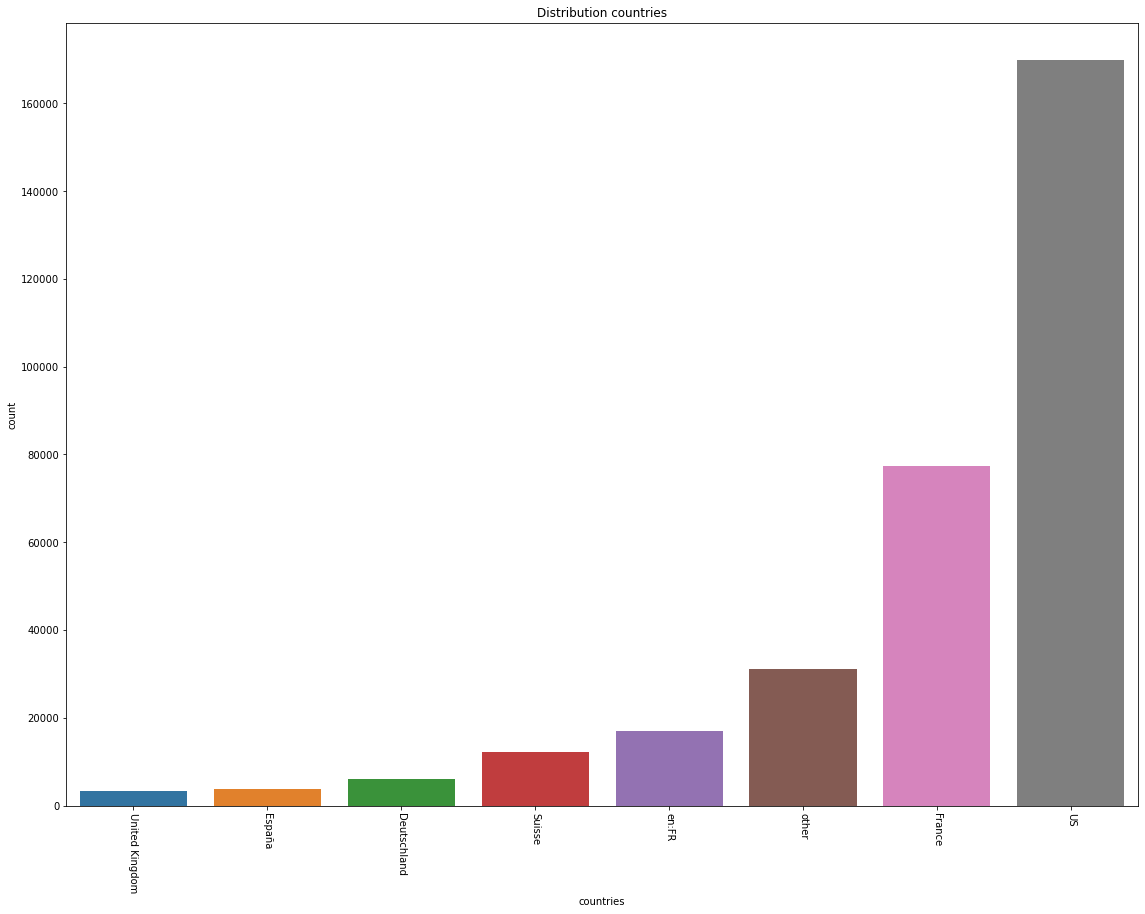


nb of index 'United Kingdom': 3246



--------------------
countries_tags
-------------------- 

unique values : 720
duplicates :    319919


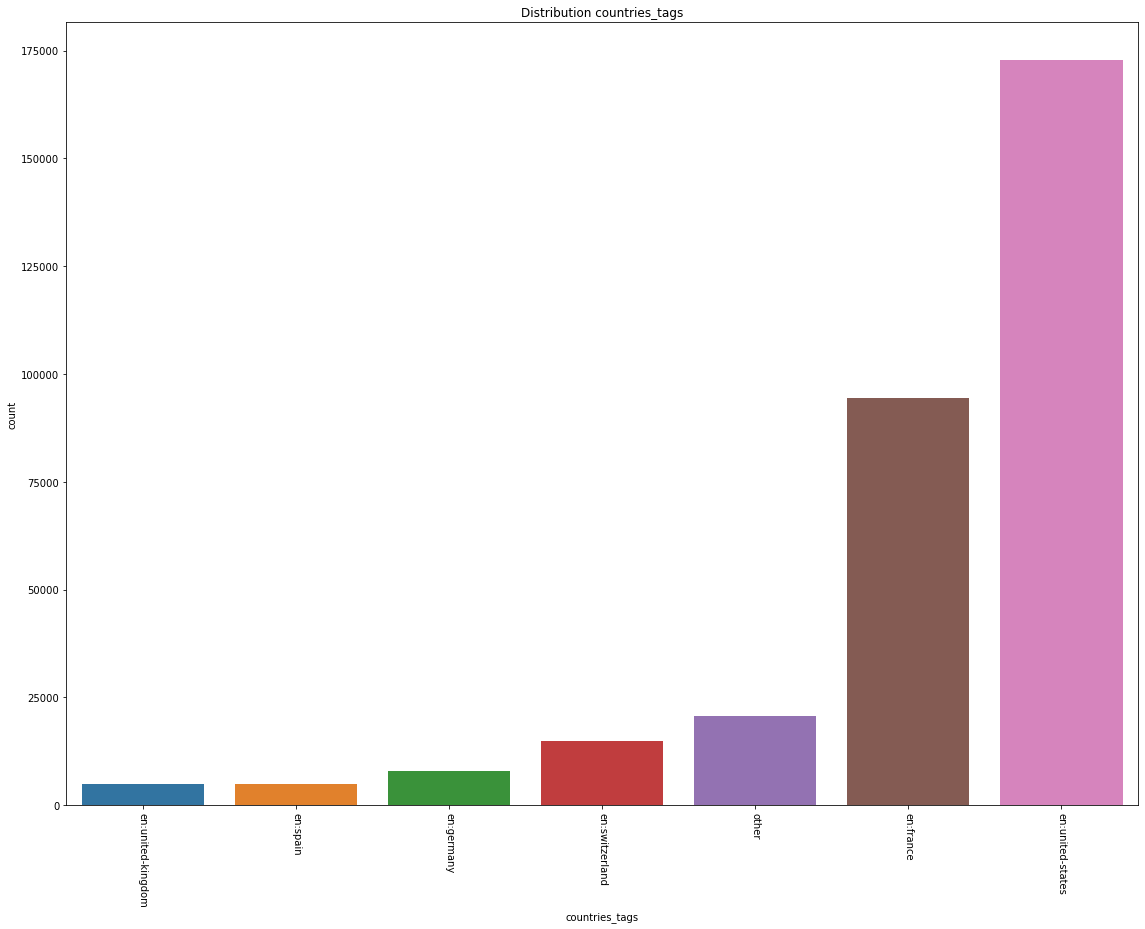


nb of index 'en:united-kingdom': 4824



--------------------
countries_fr
-------------------- 

unique values : 718
duplicates :    319921


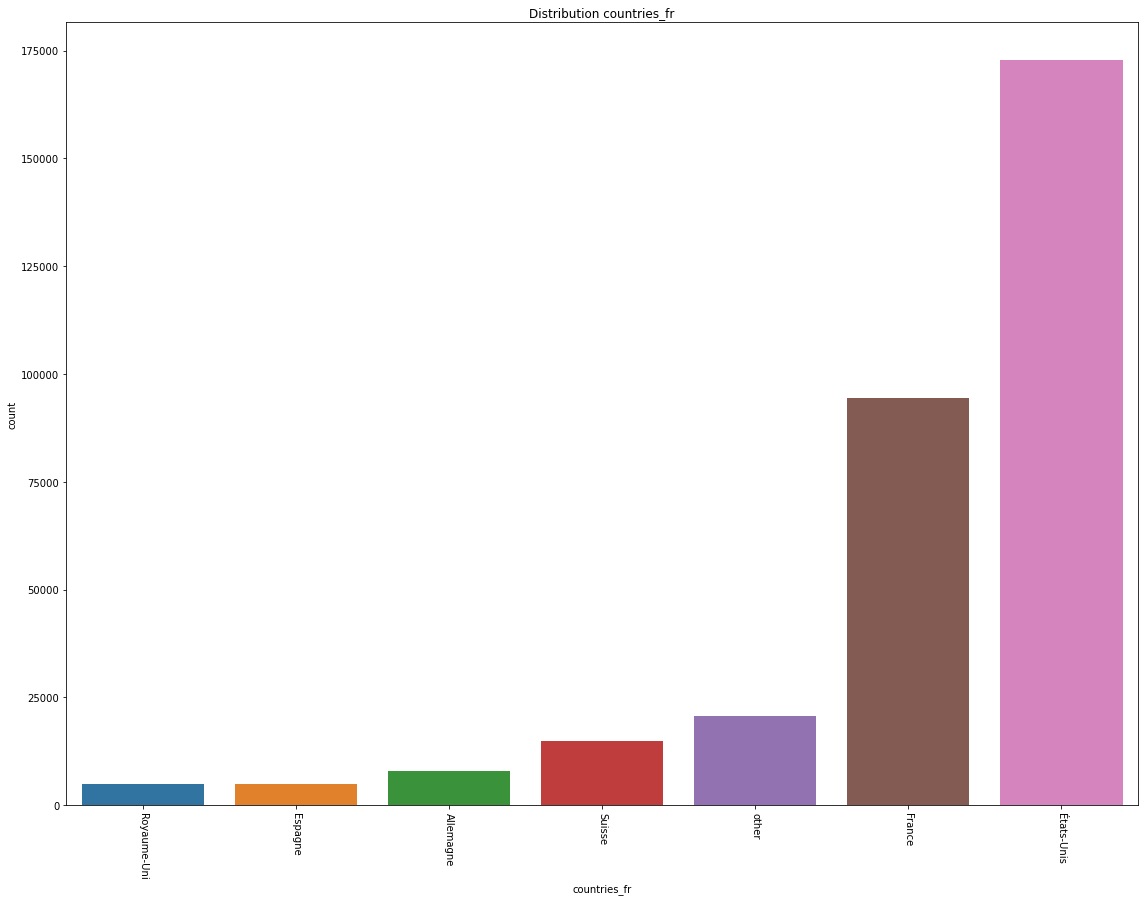


nb of index 'Royaume-Uni': 4824





In [18]:
columns = ['countries', 
           'countries_tags', 
           'countries_fr'
          ]

for column in columns:
    pf.plot_nominal_column(column, df, percentage_limit=1)
    print('\n'*2)

Best column is 'countries_fr' (less uniques values than 'countries' and simpler formating than 'countries_tags')

In [19]:
df = df.drop(['countries', 'countries_tags'], axis=1)

#### Nutri-grade

In [20]:
# nutri-grade should be in (a, b, c, d, e)

values = list(df['nutrition_grade_fr'].dropna().unique())
print(sorted(values))

['a', 'b', 'c', 'd', 'e']


#### Nutri-score (fr and uk)

In [21]:
# nutrition score should be between -15 and 40
df['nutrition-score-fr_100g'].describe()

count    221147.000000
mean          9.165365
std           9.056116
min         -15.000000
25%           1.000000
50%          10.000000
75%          16.000000
max          40.000000
Name: nutrition-score-fr_100g, dtype: float64

In [22]:
df['nutrition-score-uk_100g'].describe()

count    221147.000000
mean          9.057903
std           9.183827
min         -15.000000
25%           1.000000
50%           9.000000
75%          16.000000
max          40.000000
Name: nutrition-score-uk_100g, dtype: float64

In [23]:
nutri_scores = ['nutrition-score-uk_100g', 'nutrition-score-fr_100g']
corr = pf.correlation_matrix(nutri_scores, df, print_result=False)
print('corr =', corr['nutrition-score-uk_100g']['nutrition-score-fr_100g'])

corr = 0.98622102663164


In [24]:
# nutri-score formula is from uk, the french one uses a derived formula
# keep the french version because we only have the french nutri-grade

df = df.drop('nutrition-score-uk_100g', axis=1)

#### Salt and sodium

In [25]:
corr = pf.correlation_matrix(['salt_100g', 'sodium_100g'], df, print_result=False)
print(corr['salt_100g']['sodium_100g'])

0.9999999999452398


In [26]:
# Almost perfect correlation, so 'sodium_100g' column is redundant.
# Use it to complete 'salt_100g' and drop it

is_nan = df['salt_100g'].isna()
print(df['sodium_100g'][is_nan].sum())

# no values from 'sodium' to complete the NaNs in 'salt', so drop 'sodium'
df = df.drop('sodium_100g', axis=1)

0.0


#### Energy

In [27]:
# determine max value for energy in 100g

Kcal_fat_1g = 9
J_per_cal = 4.184

Kcal_fat_100g = Kcal_fat_1g * 100
KJ_fat_100g = Kcal_fat_100g * J_per_cal

max_energy_value = KJ_fat_100g
print(max_energy_value, '\n')

3765.6000000000004 



In [28]:
# use it to clean 'energy_100g'

column = 'energy_100g'
anomaly = (df[column] > max_energy_value)
df['energy_100g'][anomaly] = np.nan
print(anomaly.sum())

554


C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Column groups

#### Check negative values

In [29]:
quantitative_columns = ['additives_n', 
                        'ingredients_from_palm_oil_n', 
                        'ingredients_that_may_be_from_palm_oil_n', 
                        'energy_100g', 
                        'fat_100g', 
                        'saturated-fat_100g', 
                        'monounsaturated-fat_100g', 
                        'polyunsaturated-fat_100g', 
                        'trans-fat_100g', 
                        'cholesterol_100g', 
                        'carbohydrates_100g', 
                        'sugars_100g', 
                        'fiber_100g', 
                        'proteins_100g', 
                        'salt_100g', 
                        'alcohol_100g', 
                        'vitamin-a_100g', 
                        'vitamin-c_100g', 
                        'vitamin-d_100g', 
                        'vitamin-b1_100g', 
                        'vitamin-b2_100g', 
                        'vitamin-b6_100g', 
                        'vitamin-b9_100g', 
                        'vitamin-b12_100g', 
                        'vitamin-pp_100g', 
                        'potassium_100g', 
                        'calcium_100g', 
                        'phosphorus_100g', 
                        'iron_100g', 
                        'magnesium_100g', 
                        'zinc_100g', 
                        'nutrition-score-fr_100g', 
                        'nutrition-score-uk_100g', 
                       ]


# check negative values (except for nutri-score)

for column in quantitative_columns:
    if column in ['nutrition-score-fr_100g', 'nutrition-score-uk_100g']:
        continue
    
    original = df[column].count()
    negatives = (df[column] < 0)
    df[column][negatives] = np.nan
    new = df[column].count()
    
    res = new - original
    if res > 0:
        print(column, ':', res)

C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Check for values over 100

In [30]:
max_value = 100

max_100_columns = ['fat_100g', 
                   'saturated-fat_100g', 
                   'monounsaturated-fat_100g', 
                   'polyunsaturated-fat_100g', 
                   'trans-fat_100g', 
                   'cholesterol_100g', 
                   'carbohydrates_100g', 
                   'sugars_100g', 
                   'fiber_100g', 
                   'proteins_100g', 
                   'salt_100g', 
                   'alcohol_100g', 
                  ]


for column in max_100_columns:
    anomaly = (df[column] > max_value)
    print(column, ':', anomaly.sum())
    df[column][anomaly] = np.nan

C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


fat_100g : 4
saturated-fat_100g : 3
monounsaturated-fat_100g : 1
polyunsaturated-fat_100g : 0
trans-fat_100g : 5
cholesterol_100g : 0
carbohydrates_100g : 19
sugars_100g : 12
fiber_100g : 4
proteins_100g : 1
salt_100g : 158
alcohol_100g : 0


#### In column_groups, check if sum is over a certain value

In [31]:
max_sum_value = 100

column_group = ['fat_100g',
                'carbohydrates_100g',
                'proteins_100g',
                'salt_100g'
               ]

total = df[column_group].sum(axis=1)
anomaly = (total > max_sum_value)
print(anomaly.sum())

nb_exemples = 5
df[column_group][anomaly].head(nb_exemples)

# We don't know which values are false.
# There isn't a lot of problematic rows so drop all values
df[column_group][anomaly] = np.nan

4481


C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [32]:
general_column = 'carbohydrates_100g'

partial_column = 'sugars_100g'

anomaly = (df[partial_column] > df[general_column])
print(partial_column, ':', anomaly.sum(), '\n')
if anomaly.sum():
    print(df[[general_column, partial_column]][anomaly].head(nb_exemples))
    print('\n')
    df[column][anomaly] = np.nan

sugars_100g : 683 

      carbohydrates_100g  sugars_100g
379                72.50        75.00
1509                3.57         7.14
1510                3.57         7.14
1511                3.57         7.14
2079                5.71         6.12




C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [33]:
general_column = 'fat_100g'

partial_columns = ['saturated-fat_100g', 
                   'monounsaturated-fat_100g', 
                   'polyunsaturated-fat_100g'
                  ]

for partial_column in partial_columns:
    anomaly = (df[partial_column] > df[general_column])
    print(partial_column, ':', anomaly.sum(), '\n')
    if anomaly.sum():
        print(df[[general_column, partial_column]][anomaly].head(nb_exemples))
        print('\n')
        df[column][anomaly] = np.nan

saturated-fat_100g : 353 

      fat_100g  saturated-fat_100g
2322      0.00                1.25
3450      1.31                1.62
5839      9.21               21.05
5840      9.21               21.05
6320      1.79                5.36


monounsaturated-fat_100g : 17 

       fat_100g  monounsaturated-fat_100g
30416      0.00                      1.76
36014      0.00                      2.65
36016      0.00                      2.65
46580     10.00                     16.67
58179      0.03                      0.08


polyunsaturated-fat_100g : 26 

       fat_100g  polyunsaturated-fat_100g
6633       0.00                     66.67
21215      0.00                     50.00
51016      8.93                     25.00
51017      8.93                     25.00
75555      3.91                      4.69




C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Vincent\Anaconda3\envs\oc_projet_3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Check column completion again

In [34]:
print(df.shape, '\n')

# make dict with nb values and percentage completion of each column

completion_dict = {}
for column in df.columns:
    nb_values = df[column].notna().sum()
    percent = 100 * nb_values / df.shape[0]
    completion_dict[column] = [nb_values, percent]

    
# shows percentage of completion for each column    

print('column_name : nb_values  (percentage_of_completion)', '\n\n')
for column in completion_dict:
    nb_values = completion_dict[column][0]
    percent = completion_dict[column][1]
    print(f'{column} : {nb_values}  ({int(percent)}%)')
    print()

(320639, 155) 

column_name : nb_values  (percentage_of_completion) 


code : 320638  (99%)

url : 320638  (99%)

creator : 320637  (99%)

created_t : 320639  (100%)

created_datetime : 320637  (99%)

last_modified_t : 320639  (100%)

last_modified_datetime : 320639  (100%)

product_name : 302883  (94%)

generic_name : 52768  (16%)

quantity : 104787  (32%)

packaging : 78946  (24%)

packaging_tags : 78947  (24%)

brands : 292267  (91%)

categories : 84375  (26%)

categories_tags : 84374  (26%)

categories_fr : 84375  (26%)

origins : 22166  (6%)

origins_tags : 22129  (6%)

manufacturing_places : 36473  (11%)

manufacturing_places_tags : 36467  (11%)

labels : 46546  (14%)

labels_tags : 46631  (14%)

labels_fr : 46632  (14%)

emb_codes : 29305  (9%)

emb_codes_tags : 29301  (9%)

first_packaging_code_geo : 18803  (5%)

cities : 1  (0%)

cities_tags : 20298  (6%)

purchase_places : 58161  (18%)

stores : 51692  (16%)

countries_fr : 320359  (99%)

ingredients_text : 248851  (77%)

all

### Drop all columns under a percentage threshold

In [35]:
threshold = 1

drop_list = []
for column in completion_dict:
    nb_values = completion_dict[column][0]
    percent = completion_dict[column][1]
    if percent < threshold:
        drop_list.append(column)

# dropping all columns at once is way faster than calling df.drop() each time
if drop_list:
    df = df.drop(drop_list, axis=1)
print(df.shape)

(320639, 81)


###  Drop columns that will not be used in this project
#### (this list should be changed if the goal  of the analysis is different)

In [36]:
columns_to_drop = ['code', 
                   'url', 
                   'creator', 
                   'created_t', 
                   'created_datetime', 
                   'last_modified_t', 
                   'last_modified_datetime', 
                   'quantity', 
                   'packaging', 
                   'packaging_tags', 
                   'origins', 
                   'origins_tags', 
                   'manufacturing_places', 
                   'manufacturing_places_tags', 
                   'labels', 
                   'labels_tags', 
                   'labels_fr', 
                   'emb_codes', 
                   'emb_codes_tags', 
                   'first_packaging_code_geo', 
                   'cities', 
                   'cities_tags', 
                   'purchase_places', 
                   'stores', 
                   'ingredients_text', 
                   'allergens', 
                   'traces', 
                   'traces_tags', 
                   'traces_fr', 
                   'serving_size', 
                   'ingredients_from_palm_oil_tags', 
                   'ingredients_that_may_be_from_palm_oil_tags', 
                   'states', 
                   'states_tags', 
                   'states_fr', 
                   'image_url', 
                   'image_small_url', 
                  ]

# take care of the already dropped columns
not_exist = []
for column in columns_to_drop:
    if column not in df.columns:
        print(column)
        not_exist.append(column)
for column in not_exist:
    columns_to_drop.remove(column)

df = df.drop(columns_to_drop, axis=1)
print('\n', df.shape)

cities

 (320639, 45)


### Save result as csv file

In [37]:
base = r"D:\OpenClassrooms\projet_3"
name = "clean_data"

save_path = os.path.join(base, name + '.csv')
print(save_path)

if not test_mode:
    df.to_csv(save_path, index=False)


D:\OpenClassrooms\projet_3\clean_data.csv


#### Test if the saved dataframe is readable (the separator is now ",")

In [38]:
test = pd.read_csv(save_path, sep=',')
print(test.shape)

(320639, 45)
